# Introduction: GBM Hyperparameter Optimization

In this notebook we will walk through Bayesian Optimization of the hypterparameters for a Gradient Boosting Machine. We will compare the results of random search (implemented manually) with a Bayesian Method known as Tree Parzen Estimator implemented Hyperopt, an open-source Python library.

In [1]:
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

## Data

For this notebook, we will work with the Caravan Insurance Challenge dataset [available on Kaggle](https://www.kaggle.com/uciml/caravan-insurance-challenge). The objective is to determine whether or not a potential customer will buy an insurnace policy by training a model on past data. This is a straightforward supervised machine learning classification task: given past data, we want to train a model to predict a binary outcome on testing data.  

In [2]:
# Read in data and separate into training and testing sets
data = pd.read_csv('data/caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)

train.head()

Train shape:  (5822, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


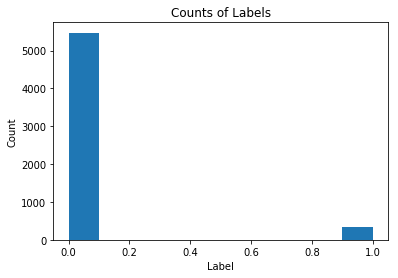

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

This is an imbalanced class problem: there are far more observations where an insurance policy was not bought (0) than when the policy was bought (1). Therefore, accuracy is a poor metric to use for this task. Instead, we will use the common classification metric of Receiver Operating Characteristic Area Under the Curve (ROC AUC). Randomly guessing on a classification problem will yield an ROC AUC of 0.5. For a better baseline model, we can train a default Gradient Boosting Machine and have it make predictions.

### Gradient Boosting Machine Default Model

We will use the LightGBM implementation of the gradient boosting machine. This is much faster than the Scikit-Learn implementation and achieves results comparable to extreme gradient boosting, XGBoost.

In [4]:
model = lgb.LGBMClassifier(random_state=50)
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=50,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

For our baseline, we will leave all of the parameters at the default values. All we need to do is fit the model on the training data and make predictions on the testing data.

In [5]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))


The baseline score on the test set is 0.7143.
The baseline training time is 0.1669 seconds


# Random Search by Hand

The first method we can implement is random search. Each iteration, we choose a random set of model hyperparameters from a search space. Empirically, random search is very effective, returning nearly as good results as grid search with a significant reduction in time spent searching. 

Random search can be implemented in the Scikit-Learn library using `RandomizedSearchCV` because we are using the Scikit-Learn LightGBM API. 
However, this does not support training with early stopping, which is the most effective method for determining the optimal number of iterations to use. If we don't use early stopping, then the number of iterations (equivalently the number of estimators trained) becomes another hyperparameter to optimize. Therefore, we will implement random search ourselves with a defined parameter grid, using Early Stopping.

In [6]:
import random

# Domain 

In random search, as in Bayesian optimization, we have a domain over which we search for the best hyperparameters. In terms of a random or grid search, this is generally known as a hyperparameter grid. First, let's look at all of the hyperparamters that need to be tuned.

In [7]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Based on the default values, we can construct the following hyperparameter grid. It's difficult to say ahead of time what choices will work best, so we will use a wide range of values for most of the hyperparameters. Some of these are discrete choices, such as `boosting_type`, while others are continuous values like `reg_alpha` and `reg_lambda` which are regularization hyperparamters between 0 and 1.0. The `subsample_dist` will be used for the `subsample` parameter but we can't just put it in the param grid because the `boosting_type=goss` does not support row subsampling. Therefore we will use an `if` statement in our evaluation to choose a subsample ratio if the boosting type is not `goss`.

In [8]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

Let's look at two of the distributions, the `learning_rate` and the `num_leaves`. The learning rate is typically [represented by a logarithmic distribution](https://www.quora.com/Why-does-one-sample-the-log-space-when-searching-for-good-Hyper-Parameters-for-Machine-Learning) because it can vary over several orders of magnitude. `np.logspace` returns values evenly spaced over a log-scale (so if we take the log of the resulting values, the distribution will be uniform.)

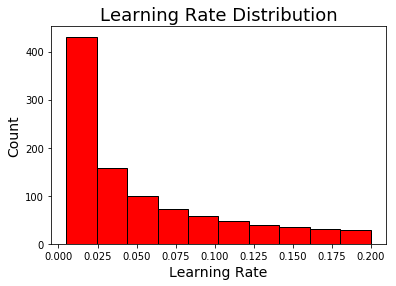

In [9]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

We can see that smaller values of the learning rate are more common. The width of the domain is fairly large, so hopefully the best learning rate is somewhere in the domain. 

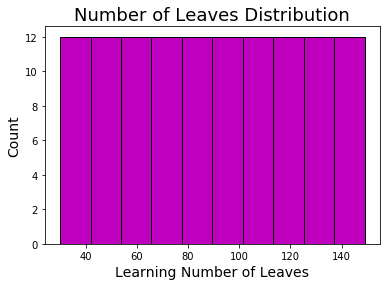

In [10]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

This is a pretty simple domain. Let's look at how we sample a set of hyperparameters from our grid using a dictionary comprehension.

In [11]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6444444444444444,
 'learning_rate': 0.0653310906134197,
 'min_child_samples': 385,
 'num_leaves': 137,
 'reg_alpha': 0.8571428571428571,
 'reg_lambda': 0.7142857142857142,
 'subsample_for_bin': 160000}

To add a `subsample` ratio if the `boosting_type` is not `goss`, we can use an if statement.

In [12]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6444444444444444,
 'learning_rate': 0.0653310906134197,
 'min_child_samples': 385,
 'num_leaves': 137,
 'reg_alpha': 0.8571428571428571,
 'reg_lambda': 0.7142857142857142,
 'subsample': 0.9595959595959596,
 'subsample_for_bin': 160000}

We set the subsample to 1.0 if boosting type is goss which is the same as not using any subsampling. 

### Implementing Random Search

We have our domain and our algorithm (random selection). The other two parts we need for an optimization problem are an objective function and an object to keep track of the results. Tracking the results will be done via a `dataframe` where each row will hold one evaluation of the objective function.

In [13]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'train_loss', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

The objective function will take in the hyperparameters and return the a single real value to minimize. We already choose our metric as ROC AUC and now we need to figure out how to measure it. We can't evaluate the ROC AUC on the test set because that would be cheating. Instead we must use a validation set to tune the model and hope that the results translate to the test set. 

A better approach than drawing the validation set from the training data (thereby limiting the amount of training data we have) we can use __KFOLD__ cross validation. In addition to not limiting the training data, this method should also give us a better estimate of generalization error on the test set because we will be using K validations rather than only one. For this example we will use 10-fold cross validation which means testing and training each set of model hyperparameters 10 times, each time using a different subset of the training data as the validation set. The objective function will return a list of metrics, the primary one of which is the validation AUC ROC. We also want to make sure to save the hyperparameters so we know which ones are optimal (or the best out of those we tried).

In [14]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random Search objective function. 
       Takes in hyperparameters and outputs a list of results to be saved."""
    
    k_fold = KFold(n_splits = n_folds)
    
    # Create the model with the parameters
    model = lgb.LGBMClassifier(class_weight = params['class_weight'], boosting_type = params['boosting_type'], 
                               num_leaves = params['num_leaves'], learning_rate = params['learning_rate'], 
                               subsample_for_bin = params['subsample_for_bin'], min_child_samples = params['min_child_samples'], 
                               reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'], 
                               colsample_by_tree = params['colsample_bytree'], subsample = params['subsample'], 
                               n_estimators = 10000, n_jobs = -1, objective = 'binary', verbose=-1, verbose_eval = False)
    
    
     # Empty lists for records
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    start = timer()
    
    # Split the data
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = -1);
        
        
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    end = timer()
    
    eval_time = end - start
    
    # Average the scores
    loss = 1 - np.mean(valid_scores)
    train_loss = 1 - np.mean(train_scores)
    estimators = int(np.mean(number_estimators))
    
    # Return a list of results
    return [loss, params, iteration, train_loss, estimators, eval_time]

Now we can write a loop to iterate through evals, each time choosing a different set of hyperparameters to evaluate. Each time through the function, the results are saved to the dataframe. (The `%%capture` magic captures any outputs from running a cell in a Jupyter Notebook. This is useful because the output from a LightGBM training run cannot be suppressed.)

In [15]:
%%capture 

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

In [16]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.head()

,loss,params,iteration,train_loss,estimators,time
172,0.221868,"{'class_weight': 'balanced', 'boosting_type': ...",172,0.200518,137,2.82021
435,0.222164,"{'class_weight': 'balanced', 'boosting_type': ...",435,0.145441,42,8.10588
486,0.223174,"{'class_weight': 'balanced', 'boosting_type': ...",486,0.125877,119,13.4255
232,0.223705,"{'class_weight': None, 'boosting_type': 'gbdt'...",232,0.174416,15,3.80251
245,0.223747,"{'class_weight': 'balanced', 'boosting_type': ...",245,0.197056,127,2.76634


As a reminder, the baseline gradient boosting model achieved a score of 0.71 on the training set. We can use the best parameters from random search and evaluate them on the testing set. 

What were the hyperparameters that returned the highest score on the objective function?

In [17]:
random_results.iloc[0, 1]

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6444444444444444,
 'learning_rate': 0.1362225405289103,
 'min_child_samples': 455,
 'num_leaves': 59,
 'reg_alpha': 0.836734693877551,
 'reg_lambda': 0.4897959183673469,
 'subsample': 1.0,
 'subsample_for_bin': 100000}

The `estimators` column holds the average number of estimators trained with early stopping. We can use this as the optimal number of estimators to use in the gbm.

In [18]:
# Find the best parameters and number of estimators
best_random_params = random_results.iloc[0, 1]
best_random_estimators = random_results.iloc[0, 4]
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.iloc[0, 2]))

The best model from random search scores 0.7276 on the test data.
This was achieved using 172 search iterations.


Not much better than the baseline. Using more evaluations will increase the score, but at the cost of more optimization time. Now, we can move on to Bayesian methods and see if they are able to achieve better results.

# Bayesian Hyperparameter Optimization using Hyperopt

For Bayesian optimization, we need the following four parts:

1. Objective function
2. Domain space
3. Hyperparameter optimization algorithm
4. History of results

We already used all of these in random search, but for Hyperopt we will have to make a few changes.

## Objective Function 

This objective function will still take in the parameters but it will return not a list but a dictionary. The only requirement for an objective function in Hyperopt is that it has a key in the return dictionary called `"loss"` to minimize and a key called `"status"` indicating if the evaluation was successful. 

If we want to keep track of the number of iterations, we can declare a global variables called `ITERATION` that is incremented every time the function is called. In addition to returning comprehensive results, every time the function is evaluated, we will write the results to a new line of a csv file. This can be useful for extremely long evaluations if we want to check on the progress (this might not be the most elegant solution, but it's better than printing to the console because our results will be saved!)

The most important part of this function is that now we need to return a __value to minimize__ and not the raw ROC AUC. We are trying to find the best value of the objective function, and even though a higher ROC AUC is better, Hyperopt works to minimize a function. Therefore, a simple solution is to return 1 - ROC. 

In [19]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    k_fold = KFold(n_splits = n_folds)
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    
    model = lgb.LGBMClassifier(**params, n_estimators = 10000, objective = 'binary', n_jobs = -1, verbose = -1)
    
    # Keep track of the scores
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    start = timer()
    
    # KFold cross validation
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = -1)
    
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    end = timer()
    run_time = end - start
    
    # fmin needs a loss to minimize, take average validation across folds
    loss = 1 - np.mean(valid_scores)
    train_loss = 1 - np.mean(train_scores)
    
    # average number of estimators
    estimators = int(np.mean(number_estimators))

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, train_loss, estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train': train_loss, 'estimators': estimators, 
            'train_time': run_time, 'status': STATUS_OK}

## Domain Space

Specifying the domain (called the `space` in Hyperopt) is a little trickier than in grid search. In Hyperopt, and most other Bayesian optimization frameworks, the domian is not a strictly defined grid but rather probability distributions for each hyperparameter. Therefore, for each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images! 

In [20]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

First we will go through an example of the learning rate. Again, we are using a log-uniform space for the learning rate defined from 0.005 to 0.2 (same as with the grid.) This time, when we graph the domain, it's more accurate to see a kernel density estimate plot than a histogram (although both show distributions). 

In [21]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

We can visualize the learning rate by sampling from the space using a Hyperopt utility. Here we plot 10000 samples.

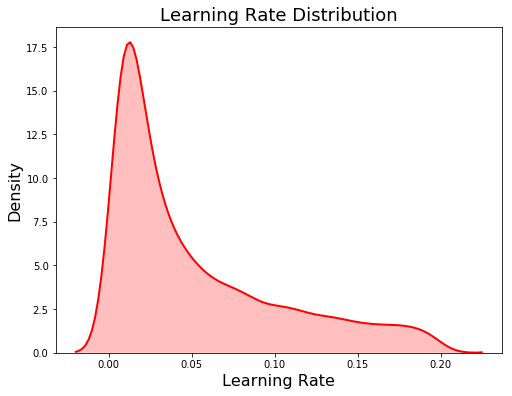

In [22]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

The number of leaves is again a uniform distribution. Here we used `quniform` which means a discrete uniform (as opposed to continuous).

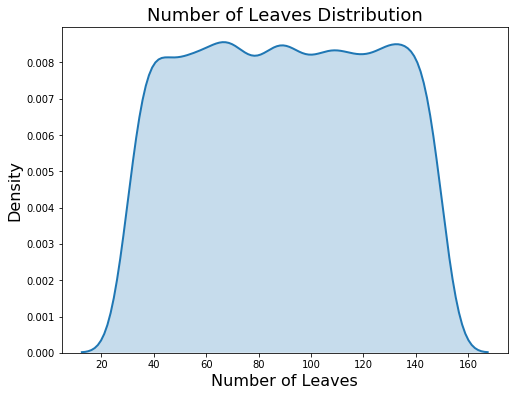

In [23]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Complete Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the `choice` variable. In Hyperopt, we can use nested conditional statements to indicate hyperparameters that depend on other hyperparameters. For example, we know that `goss` boosting type cannot use subsample, so when we set up the `boosting_type` categorical variable, we do not set a `subsample` ratio variable while we do for the other two boosting types. Let's see this with an example:

In [24]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.7520072921575092}}

To actually set the `subsample` as a top-level key in the parameter dictionary, we can use a little conditional logic. Instead of an `if` statement, we use the Python `dict.get` method with a default value of 1.0 to set the `subsample` to whatever the value is in the `subsample` key under the `boosting_type` key, or to 1.0 if the `subsample` key is not present indicating the boosting type is `goss`. Here's the code: (This is implemented in the objective function)

In [25]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'gbdt', 'subsample': 0.7520072921575092}

All of this is necessary because the gbm cannot use the nested dictionary so we need to set the `boosting_type` and `subsample` as top level keys.


With those gymnastics out of the way, we can define the entire domain space as below.

In [26]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

### Example of Sampling from the space

Let's sample from the space (using the conditional logic) to see the result of each draw. Every time we run this code, the results will change.

In [27]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.6775227520021032,
 'learning_rate': 0.016212614706523767,
 'min_child_samples': 490.0,
 'num_leaves': 65.0,
 'reg_alpha': 0.32027467461162884,
 'reg_lambda': 0.1560322248708702,
 'subsample': 0.9005463854389633,
 'subsample_for_bin': 60000.0}

In [28]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.9329249892128408,
 'learning_rate': 0.018695083452250762,
 'min_child_samples': 420.0,
 'num_leaves': 125.0,
 'reg_alpha': 0.44446702413004113,
 'reg_lambda': 0.5401661425616505,
 'subsample': 1.0,
 'subsample_for_bin': 40000.0}

## Optimization Algorithm

Although this is the most technical part of Bayesian optimization, defined the algorithm to use in Hyperopt is simple. We will use the Tree Parzen Estimator which is a method for constructing the surrogate function and choosing the next hyperparameters to evaluate. If we do not know now to configure the algorithm, we can use the `suggest` method.

In [29]:
from hyperopt import tpe

tpe_algorithm = tpe.suggest

## Result History

The final part is the result history. Here, we are using two methods to make sure we capture all the results:

1. A `Trials` object that stores the dictionary returned from the objective function
2. Writing to a csv file every iteration

The csv file option also lets us monitor the results of an on-going experiment. 

In [30]:
from hyperopt import Trials

bayes_trials = Trials()

In [31]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_loss', 'estimators', 'train_time'])
of_connection.close()

## Optimization

We have everything in place needed to run the optimization. First we declare the global variable that will be used to keep track of the number of iterations. Then, we call `fmin` passing in everything we defined above and the maximum number of iterations to run.

In [32]:
from hyperopt import fmin

In [33]:
%%capture

# Global variable
global  ITERATION

ITERATION = 1

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1)

In [34]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 35,
  'iteration': 120,
  'loss': 0.21811036462373767,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8445624478058252,
   'learning_rate': 0.19964459370987267,
   'min_child_samples': 235,
   'num_leaves': 66,
   'reg_alpha': 0.7932408770589917,
   'reg_lambda': 0.14585611827507913,
   'subsample': 1.0,
   'subsample_for_bin': 220000},
  'status': 'ok',
  'train': 0.1645038310903587,
  'train_time': 2.449957162702958},
 {'estimators': 240,
  'iteration': 482,
  'loss': 0.21933612010507297,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8673810537782373,
   'learning_rate': 0.10205761401361375,
   'min_child_samples': 490,
   'num_leaves': 72,
   'reg_alpha': 0.4271730230534095,
   'reg_lambda': 0.18732988855698218,
   'subsample': 1.0,
   'subsample_for_bin': 20000},
  'status': 'ok',
  'train': 0.20072269840842505,
  'train_time': 3.6055828432354247}]

We can access the results either through the `Trials` object or by reading in from the csv file. We can do both to make sure the results are the same (just to check!)

In [35]:
results = pd.read_csv('gbm_trials.csv')
results.sort_values('loss', ascending = True, inplace = True)
results.head()

,loss,params,iteration,train_loss,estimators,train_time
118,0.218110,"{'boosting_type': 'goss', 'class_weight': 'bal...",120,0.164504,35,2.449957
480,0.219336,"{'boosting_type': 'goss', 'class_weight': 'bal...",482,0.200723,240,3.605583
498,0.219420,"{'boosting_type': 'goss', 'class_weight': 'bal...",500,0.204701,204,3.462231
403,0.220211,"{'boosting_type': 'goss', 'class_weight': 'bal...",405,0.190804,240,3.523500
363,0.220335,"{'boosting_type': 'goss', 'class_weight': 'bal...",365,0.196116,158,3.004708


For some reason, when we save to a file and then read back in, the dictionary of hyperparameters is saved to a string. To convert from a string back to a dictionary we can use the `ast` library and the `literal_eval` function.

In [36]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.iloc[0, 1])

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8445624478058252,
 'learning_rate': 0.19964459370987267,
 'min_child_samples': 235,
 'num_leaves': 66,
 'reg_alpha': 0.7932408770589917,
 'reg_lambda': 0.14585611827507913,
 'subsample': 1.0,
 'subsample_for_bin': 220000}

### Evaluate Best Results

Now for the moment of truth: did the optimization pay off? For this problem with a relatively small dataset, the benefits of hyperparameter optimization compared to random search are probably minor (if there are any)! Random search might turn up a better result in fewer iterations simply becuase of randomness! This problem also is not the most amenable to hyperparameter optimization because it's fairly difficult to improve much beyond the baseline score. Nonetheless, we can evaluate the best results and also look at the hyperparameter selections to see if there are any interesting trends! 

In [37]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.iloc[0, 4])
best_bayes_params = ast.literal_eval(results.iloc[0, 1])

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
        colsample_bytree=0.8445624478058252,
        learning_rate=0.19964459370987267, max_depth=-1,
        min_child_samples=235, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=35, n_jobs=-1, num_leaves=66, objective='binary',
        random_state=50, reg_alpha=0.7932408770589917,
        reg_lambda=0.14585611827507913, silent=True, subsample=1.0,
        subsample_for_bin=220000, subsample_freq=1)

In [38]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.iloc[0, 2]))

The best model from Bayes optimization scores 0.72049 AUC ROC on the test set.
This was achieved after 120 search iterations


## Inspecting Searches

One interesting thing we can do with the results is to see the different hyperparameters tried by both random search and the Tree Parzen Estimator. Since random search is choosing without regards to the previous results, we would expect that the distribution of samples should be close to domain space we defined. On the other hand, the Bayes Optimization, if given enough time, should concetrate on the "more promising" hyperparamters. 

More promising in this concept means more likely to result in a lower score on the objective function according to the probability model $P ( \text{loss}|\text{hyperparameters})$. In addition to a more directed search, we expect that the average validation loss of the Bayes Optimization should be lower than that on the random search because it chooses values likely (according to the probability model) to yield lower losses on the objective function.

To start out, we can visualize the learning rate, both the initial sampling domain, and the distributions from random search and the Bayes optimization.

In [39]:
random_results.head()

,loss,params,iteration,train_loss,estimators,time
172,0.221868,"{'class_weight': 'balanced', 'boosting_type': ...",172,0.200518,137,2.82021
435,0.222164,"{'class_weight': 'balanced', 'boosting_type': ...",435,0.145441,42,8.10588
486,0.223174,"{'class_weight': 'balanced', 'boosting_type': ...",486,0.125877,119,13.4255
232,0.223705,"{'class_weight': None, 'boosting_type': 'gbdt'...",232,0.174416,15,3.80251
245,0.223747,"{'class_weight': 'balanced', 'boosting_type': ...",245,0.197056,127,2.76634


In [40]:
# Create a new dataframe for storing parameters
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
    
random_params['iteration'] = random_results['iteration']
random_params.head()

,class_weight,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,iteration
0,balanced,goss,59,0.136223,100000,455,0.836735,0.489796,0.644444,1,0
1,balanced,dart,121,0.139274,140000,195,0.489796,0.877551,0.822222,0.782828,1
2,balanced,dart,72,0.0543171,180000,120,0.979592,0.571429,0.6,0.621212,2
3,None,gbdt,146,0.19275,200000,135,0.265306,0.408163,0.866667,0.848485,3
4,balanced,goss,107,0.185077,140000,455,0.877551,0.183673,0.733333,1,4


In [41]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['iteration'] = results['iteration']
bayes_params.head()

,boosting_type,class_weight,colsample_bytree,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,iteration
0,goss,balanced,0.844562,0.199645,235,66,0.793241,0.145856,220000,1,2
1,goss,balanced,0.867381,0.102058,490,72,0.427173,0.18733,20000,1,3
2,goss,balanced,0.813305,0.104148,480,77,0.417304,0.320225,40000,1,4
3,goss,balanced,0.964278,0.199118,480,70,0.692199,0.149486,100000,1,5
4,goss,balanced,0.933056,0.165888,475,46,0.491801,0.203198,40000,1,6


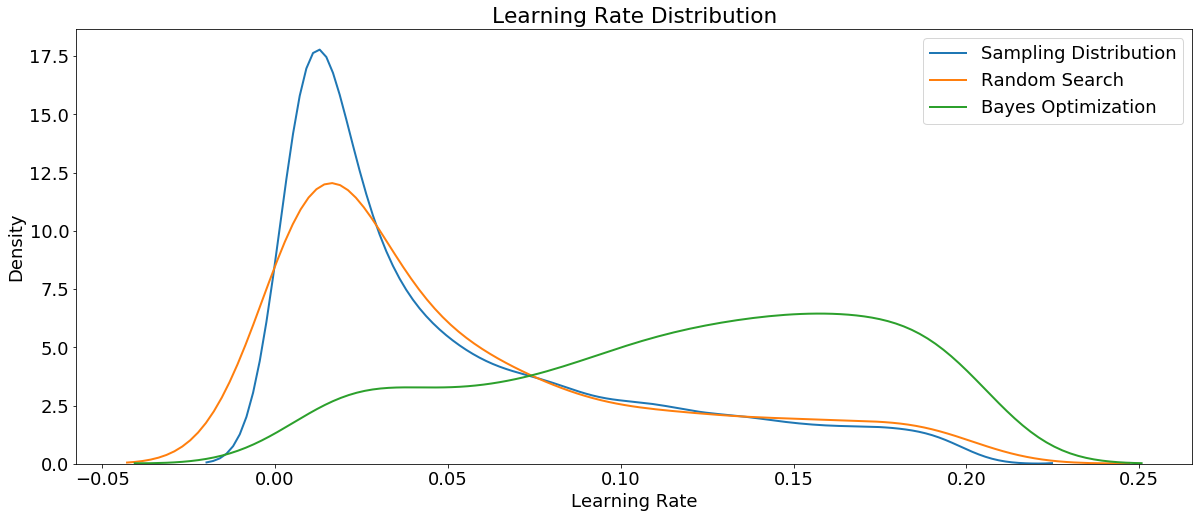

In [42]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

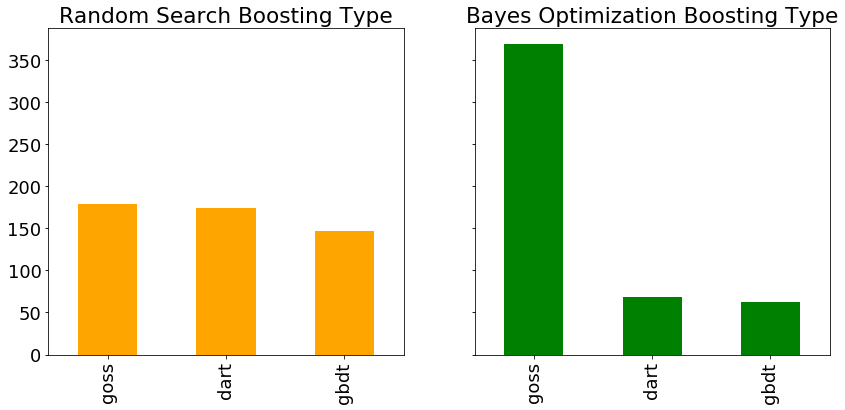

In [43]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [44]:
print('Random Search boosting type percentages')
100 * random_params['boosting_type'].value_counts() / len(random_params)

Random Search boosting type percentages


goss    35.8
gbdt    34.8
dart    29.4
Name: boosting_type, dtype: float64

In [45]:
print('Bayes Optimization boosting type percentages')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

Bayes Optimization boosting type percentages


goss    73.8
dart    13.6
gbdt    12.6
Name: boosting_type, dtype: float64

#### Plots of All Hyperparameters

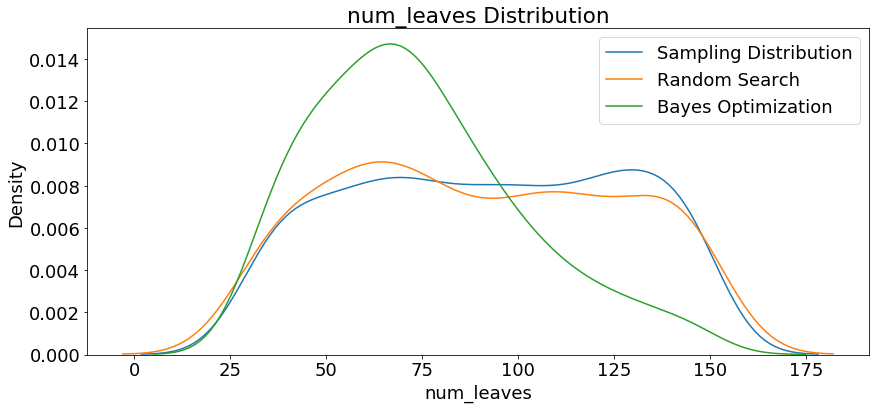

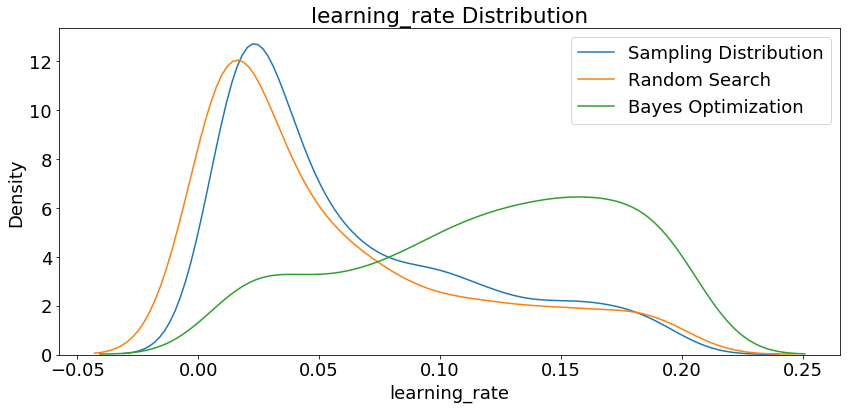

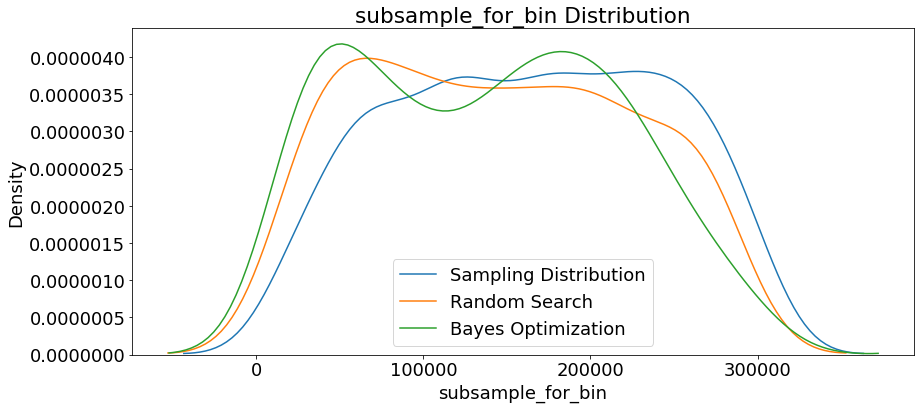

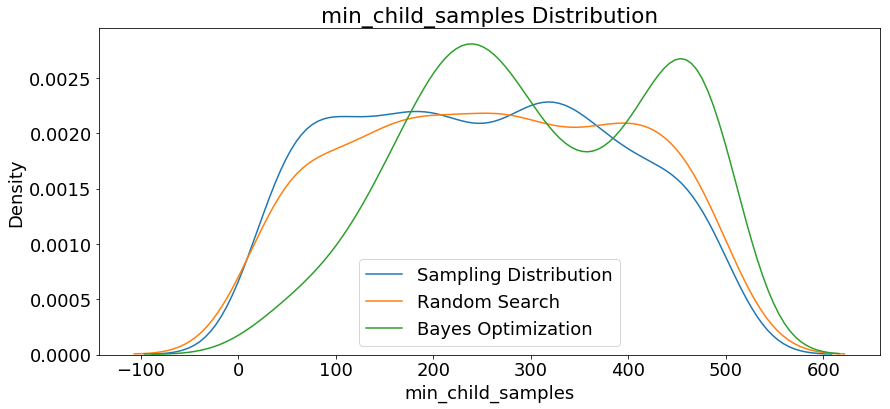

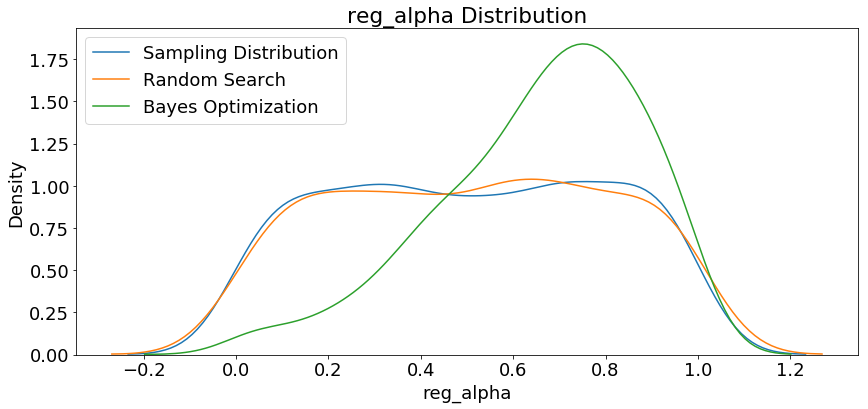

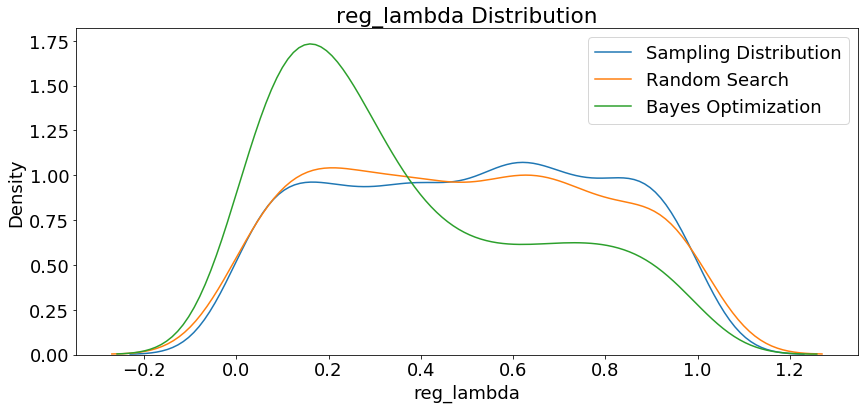

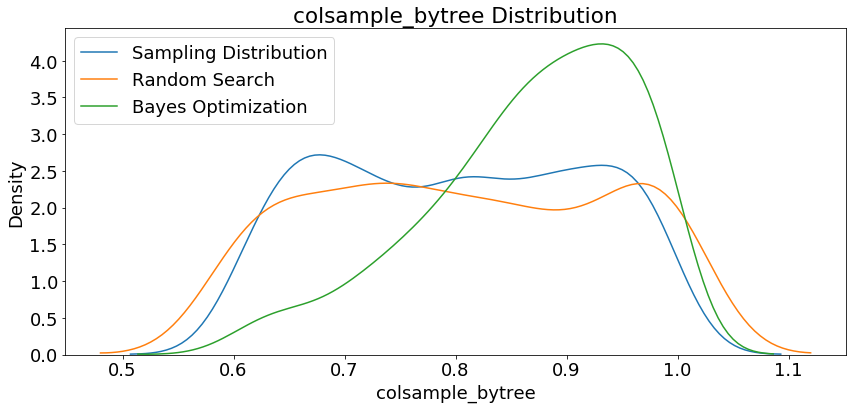

In [46]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

We can also plot the hyperparameters over time (against the number of iterations) to see how they change for the Bayes Optimization. First we will map the `boosting_type` to an integer for plotting.

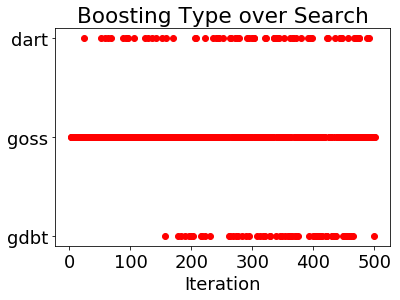

In [47]:
# Map boosting type to integer (essentially label encoding)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Plot the boosting type over the search
plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart']);
plt.xlabel('Iteration'); plt.title('Boosting Type over Search');

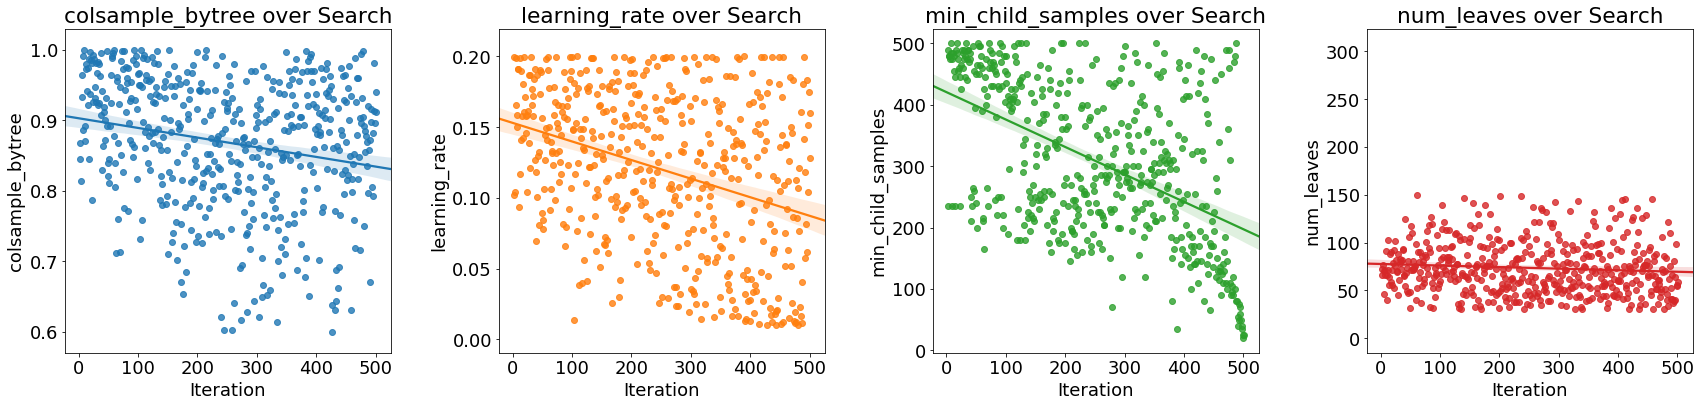

In [48]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

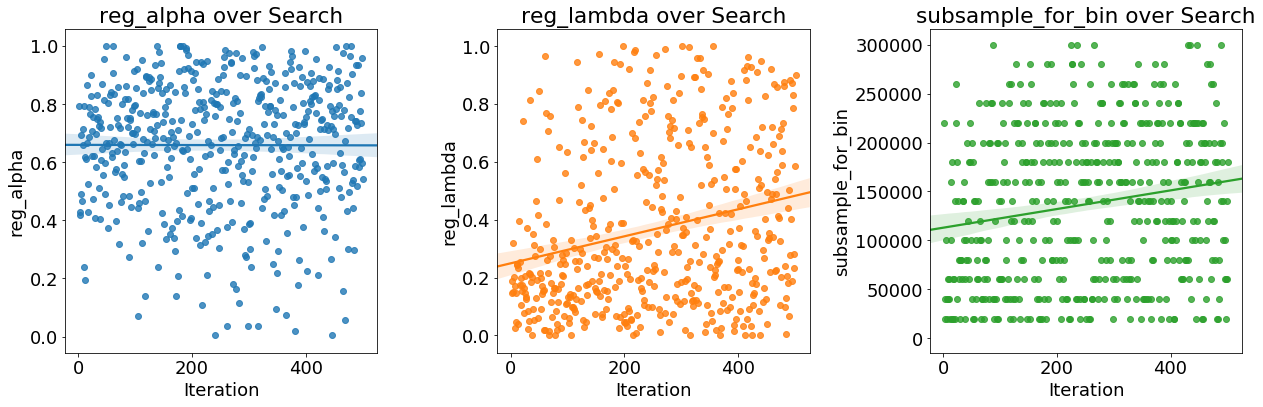

In [49]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

Finally, we can look at the losses recorded by both random search and Bayes Optimization. We would expect the average loss recorded by Bayes Optimization to be lower because this method should spend more time in promising regions of the search space.

In [50]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_results['loss'], 'iteration': random_results['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - results['loss'], 'iteration': results['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
172,0.778132,172,random
435,0.777836,435,random
486,0.776825,486,random
232,0.776295,232,random
245,0.776253,245,random


We can make histograms of the scores (not taking in account the iteration) on the same x-axis scale to see if there is a difference in the concentration of scores between the methods. 

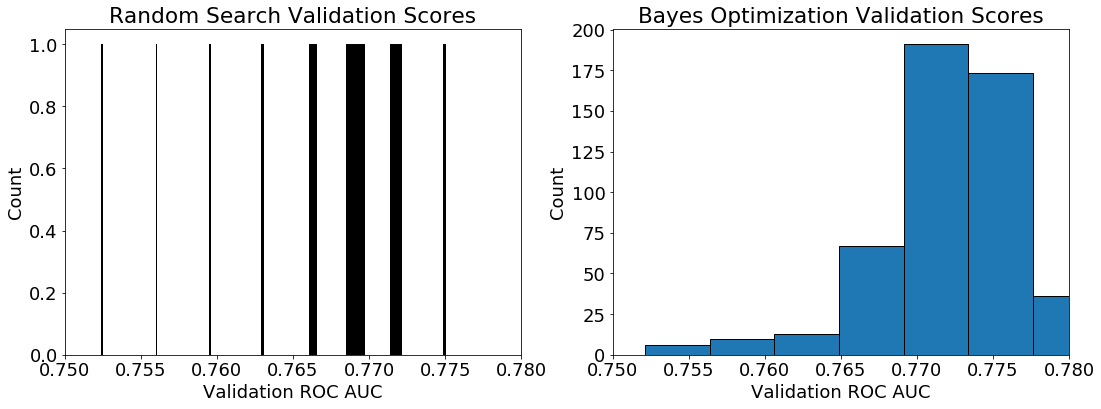

In [51]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'], label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - results['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

We see that the Bayes optimization tends to 

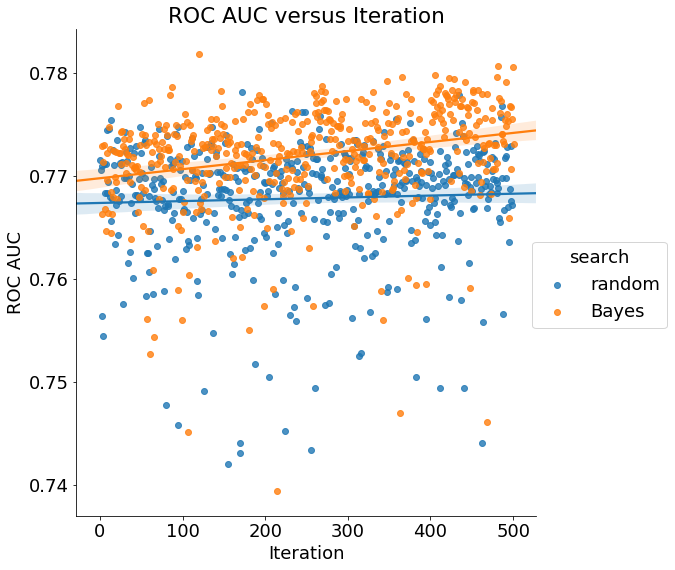

In [52]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");

To save the trials results, we can use the json format. 

In [53]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(bayes_trials.results))

## Continuation of Training

We can keep running the estimator for more iterations to get better results. Hyperopt will continue training if we [pass it a trials object that already has information on previous runs](https://github.com/hyperopt/hyperopt/issues/267). This way, we can save our trials objects and continue searching where the algorithm left off if we are not satisfied with the current results. This raises a good point: always save your previous results, because you never know when they will be useful! 

In [54]:
# Continue training
ITERATION = MAX_EVALS + 1

# Set more evaluations
MAX_EVALS = 1000

In [55]:
%%capture

# Use the same trials object to keep training
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1)

In [56]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 35,
  'iteration': 120,
  'loss': 0.21811036462373767,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8445624478058252,
   'learning_rate': 0.19964459370987267,
   'min_child_samples': 235,
   'num_leaves': 66,
   'reg_alpha': 0.7932408770589917,
   'reg_lambda': 0.14585611827507913,
   'subsample': 1.0,
   'subsample_for_bin': 220000},
  'status': 'ok',
  'train': 0.1645038310903587,
  'train_time': 2.449957162702958},
 {'estimators': 131,
  'iteration': 625,
  'loss': 0.21865148891106911,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8264260248433729,
   'learning_rate': 0.16456552602936736,
   'min_child_samples': 480,
   'num_leaves': 65,
   'reg_alpha': 0.42217752256935853,
   'reg_lambda': 0.1034182117353168,
   'subsample': 1.0,
   'subsample_for_bin': 60000},
  'status': 'ok',
  'train': 0.2004820525041494,
  'train_time': 2.748912000927703}]

In [57]:
results = pd.read_csv('gbm_trials.csv')
results.sort_values('loss', ascending = True, inplace = True)
results.head()

,loss,params,iteration,train_loss,estimators,train_time
118,0.218110,"{'boosting_type': 'goss', 'class_weight': 'bal...",120,0.164504,35,2.449957
623,0.218651,"{'boosting_type': 'goss', 'class_weight': 'bal...",625,0.200482,131,2.748912
790,0.218742,"{'boosting_type': 'goss', 'class_weight': 'bal...",792,0.198825,225,3.416671
833,0.219069,"{'boosting_type': 'goss', 'class_weight': 'bal...",835,0.202638,112,2.605978
972,0.219100,"{'boosting_type': 'goss', 'class_weight': 'bal...",974,0.201303,190,3.256837


In [58]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators= int(results.iloc[0, 4])
best_bayes_params = ast.literal_eval(results.iloc[0, 1])

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
        colsample_bytree=0.8445624478058252,
        learning_rate=0.19964459370987267, max_depth=-1,
        min_child_samples=235, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=35, n_jobs=-1, num_leaves=66, objective='binary',
        random_state=50, reg_alpha=0.7932408770589917,
        reg_lambda=0.14585611827507913, silent=True, subsample=1.0,
        subsample_for_bin=220000, subsample_freq=1)

In [59]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.iloc[0, 2]))

The best model from Bayes optimization scores 0.72049 AUC ROC on the test set.
This was achieved after 120 search iterations


# Conclusions

In this notebook, we saw how to use Hyperopt with the Tree Parzen Estimator to optimize the hyperparameters of a gradient boosting machine. Bayesian model-based optimization is more efficient than random search, finding a better set of model hyperparameters in fewer search iterations. This is a powerful technique that we can use on any model, so long as we can define an objective function that returns a valud to minimize and a domain space over which to search. Bayesian optimization represents a significant upgrade over random search and because of the ease of use in Python, should now serve as a default choice rather than uninformed search strategies.